# data-processing

In [ ]:
import pandas as pd
import time
import requests
from tqdm import tqdm_notebook
import json
import statistics as stat
import multiprocessing as mp


def into_pool(pool_list):
    try:
        russo_list, start, end, nas = pool_list
        stock_info = Get_Stock_Info(russo_list, start, end, nas)
        result = stock_info.launch()
        return result
    except:
        global error
        russo_list, start, end, nas = pool_list
        error.loc[-1] = russo_list
        error = error.reset_index(drop=True)


def get_nas_data(start, end):
    url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-historical-data"

    querystring = {"frequency": "1d", "filter": "history", "period1": start, "period2": end, "symbol": "%5EIXIC"}

    headers = {
        'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
        'x-rapidapi-key': "8099cb7d77msh3ebb39dd41af894p154acajsnabc8c78e3d42"
    }

    response = requests.request("GET", url, headers=headers, params=querystring)

    response = json.loads(response.text)

    for i in response['prices']:
        try:
            i['volume']
        except:
            response['prices'].remove(i)

    return response['prices']


class Get_Stock_Info:
    def __init__(self, russo_list, start, end, nas):
        self.name = russo_list[0]
        if '.' in russo_list[1]:
            self.ticker = russo_list[1].replace('.', '-')
        elif '/' in russo_list[1]:
            self.ticker = russo_list[1].replace('/', '-')
        else:
            self.ticker = russo_list[1]
        self.clas = russo_list[2]
        self.share = russo_list[3]
        self.change = russo_list[4]
        self.value = russo_list[5]
        self.start = start
        self.end = end
        self.nas = nas
        self.stock = None
        self.result = pd.DataFrame({'name': [],
                                    'ticker': [],
                                    'price': [],
                                    'volume': [],
                                    'change': [],
                                    'max_change': [],
                                    'beta': [],
                                    'industry': [],
                                    'dividendRate': []})

    def get_historical_data(self):
        url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-historical-data"

        querystring = {"frequency": "1d", "filter": "history", "period1": self.start, "period2": self.end,
                       "symbol": self.ticker}

        headers = {
            'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
            'x-rapidapi-key': "8099cb7d77msh3ebb39dd41af894p154acajsnabc8c78e3d42"
        }

        response = requests.request("GET", url, headers=headers, params=querystring)

        response = json.loads(response.text)

        for i in response['prices']:
            try:
                i['volume']
            except:
                response['prices'].remove(i)

        return response['prices']

    def get_profile(self):
        url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-profile"

        querystring = {"symbol": self.ticker}

        headers = {
            'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
            'x-rapidapi-key': "8099cb7d77msh3ebb39dd41af894p154acajsnabc8c78e3d42"
        }

        response = requests.request("GET", url, headers=headers, params=querystring)

        return json.loads(response.text)

    def launch(self):
        self.stock = pd.DataFrame(self.get_historical_data())
        self.stock['change'] = (self.stock['close'] - self.stock['open']) / self.stock['open'] * 100
        self.stock['nas_change'] = (self.nas['close'] - self.nas['open']) / self.nas['open'] * 100
        price = stat.mean(self.stock['close'])
        volume = stat.mean(self.stock['volume'])
        change = stat.mean(self.stock['change'])
        max_change = (max(self.stock['high']) - min(self.stock['low'])) / price
#         max_change = stat.mean(self.stock['max_change'])
        beta = self.stock.change.corr(self.stock.nas_change) * stat.stdev(self.stock['change']) / \
               stat.stdev(self.stock['nas_change'])
        stock_profile = self.get_profile()
        industry = stock_profile['assetProfile']['industry']
        if len(stock_profile['summaryDetail']['dividendRate']) != 0:
            dividend = stock_profile['summaryDetail']['dividendRate']['raw']
        else:
            dividend = None

        self.result.loc[-1] = [self.name, self.ticker, price, volume, change, max_change, beta, industry,
                               dividend]
        self.result = self.result.reset_index(drop=True)

        return self.result


if __name__ == '__main__':
    a = '2019-07-01 21:30:00'
    timeArray = time.strptime(a, "%Y-%m-%d %H:%M:%S")
    start = str(int(time.mktime(timeArray)))

    b = '2019-09-30 21:30:00'
    timeArray = time.strptime(b, "%Y-%m-%d %H:%M:%S")
    end = str(int(time.mktime(timeArray)))

    nas = pd.DataFrame(get_nas_data(start, end))

    russo = pd.read_csv('C:/Users/wells/ctbc_project/Russo/09-30-2019.csv', encoding='utf8')
    error = russo[russo['Ticker'].isnull()].reset_index(drop=True)
    russo = russo[russo['Ticker'].notnull()].reset_index(drop=True)
    results = pd.DataFrame({})
    for i in tqdm_notebook(range(len(russo))):
        print(i)
        r = into_pool((russo.loc[i], start, end, nas))
        print(r)
        results = pd.concat([results, r], ignore_index=True)

In [32]:
results

,name,ticker,price,volume,change,max_change,beta,industry,dividendRate
0,Mastercard Inc,MA,275.570157,3405071,-0.133419,0.144392,0.983825,Credit Services,1.60
1,NESTLE SA,NSRGY,107.618750,367829,-0.052345,0.121819,0.202866,Packaged Foods,2.76
2,BERKSHIRE HATHAWAY INC,BRK-A,309458.187500,240,-0.035182,0.097590,0.519458,Insuranceâ€”Diversified,0.00
3,HEINEKEN HOLDING N V,HKHHF,101.002812,1276,-0.058059,0.123363,0.113037,Beverages—Brewers,2.25
4,PERNOD RICARD S A /FI,PDRDF,180.143127,310,0.088542,0.141055,0.063537,Beverages—Wineries & Distilleries,3.46
5,COMPAGNIE FINANCIERE RICHEMONT AG /FI,CFRHF,80.591875,4028,-0.125005,0.191086,-0.071572,Luxury Goods,2.03
6,UNILEVER N V,UN,60.049531,1085359,0.030223,0.122232,0.304918,Household & Personal Products,1.78
7,Anheuser-Busch InBev SA/NV,BUDFF,94.857313,42898,-0.042931,0.173524,0.068708,Beveragesâ€”Brewers,2.01
8,Philip Morris International Inc.,PM,79.245000,6838537,-0.169185,0.261341,0.626023,Tobacco,4.68
9,WELLS FARGO & COMPANY/MN,WFC,47.108281,20372354,0.072536,0.171307,0.743099,Banksâ€”Diversified,2.04


In [ ]:
results.to_csv('2019-09-30 21:30:00_stock_info.csv', index=False, encoding='utf_8_sig')

# classificate

In [14]:
results.fillna(0, inplace=True)

results['volume'] = results['volume'].astype('int')

results

data = results.drop(['name', 'ticker'], axis=1)
co_matrix = []
for num in tqdm_notebook(range(len(data))):
    each_list = list(data.loc[num])
    each_co_matrix = []
    for n in range(len(each_list)):
        if n == 0:
            if each_list[n] <= 100:
                each_co_matrix.append('price <= 100')
            elif 100 < each_list[n] and each_list[n] <= 500:
                each_co_matrix.append('100 < price <= 500')
            elif 500 < each_list[n] and each_list[n] <= 1000:
                each_co_matrix.append('500 < price <= 1000')
            else:
                each_co_matrix.append('1000 < price')
        elif n == 1:
            if each_list[n] <= 10000:
                each_co_matrix.append('volume <= 10000')
            elif 10000 < each_list[n] and each_list[n] <= 100000:
                each_co_matrix.append('10000 < volume <= 100000')
            elif 100000 < each_list[n] and each_list[n] <= 1000000:
                each_co_matrix.append('100000 < volume <= 1000000')
            elif 100000 < each_list[n] and each_list[n] <= 1000000:
                each_co_matrix.append('100000 < volume <= 1000000')
            elif 1000000 < each_list[n] and each_list[n] <= 10000000:
                each_co_matrix.append('1000000 < volume <= 10000000')
            else:
                each_co_matrix.append('10000000 < volume')
        elif n == 2:
            if each_list[n] <= -1:
                each_co_matrix.append('change <= -1')
            elif -1 < each_list[n] and each_list[n] <= -0.5:
                each_co_matrix.append('-1 < change <= -0.5')
            elif -0.5 < each_list[n] and each_list[n] <= 0:
                each_co_matrix.append('-0.5 < change <= 0')
            elif 0 < each_list[n] and each_list[n] <= 0.5:
                each_co_matrix.append('0 < change <= 0.5')
            elif 0.5 < each_list[n] and each_list[n] <= 1:
                each_co_matrix.append('0.5 < change <= 1')
            elif 1 < each_list[n]:
                each_co_matrix.append('1 < change')
        elif n == 3:
            if each_list[n] <= 0.02:
                each_co_matrix.append('max_change <= 2%')
            elif 0.02 < each_list[n] and each_list[n] <= 0.04:
                each_co_matrix.append('2% < max_change <= 4%')
            elif 0.04 < each_list[n] and each_list[n] <= 0.06:
                each_co_matrix.append('4% < max_change <= 6%')
            elif 0.06 < each_list[n] and each_list[n] <= 0.08:
                each_co_matrix.append('6% < max_change <= 8%')
            elif 0.08 < each_list[n] and each_list[n] <= 0.1:
                each_co_matrix.append('8% < max_change <=10%')
            else:
                each_co_matrix.append('10% < max_change')
        elif n == 4:
            if each_list[n] <= -1.5:
                each_co_matrix.append('beta <= -1.5')
            elif -1.5 < each_list[n] and each_list[n] <= -1:
                each_co_matrix.append('-1.5 < beta <= -1')
            elif -1 < each_list[n] and each_list[n] <= -0.5:
                each_co_matrix.append('-1 < beta <= -0.5')
            elif -0.5 < each_list[n] and each_list[n] <= 0:
                each_co_matrix.append('-0.5 < beta <= -0')
            elif 0 < each_list[n] and each_list[n] <= 0.5:
                each_co_matrix.append('0 < beta <= 0.5')
            elif 0.5 < each_list[n] and each_list[n] <= 1:
                each_co_matrix.append('0.5 < beta <= 1')
            elif 1 < each_list[n] and each_list[n] <= 1.5:
                each_co_matrix.append('1 < beta <= 1.5')
            elif 1.5 < each_list[n]:
                each_co_matrix.append('1.5 < beta')
        elif n == 5:
            each_co_matrix.append(each_list[n])
        elif n == 6:
            if each_list[n] == 0:
                each_co_matrix.append('dividendRate == 0')
            elif 0 < each_list[n] and each_list[n] <= 2:
                each_co_matrix.append('0 < dividendRate <= 2')
            elif 2 < each_list[n] and each_list[n] <= 4:
                each_co_matrix.append('2 < dividendRate <= 4')
            elif 4 < each_list[n] and each_list[n] <= 6:
                each_co_matrix.append('4 < dividendRate <= 6')
            else:
                each_co_matrix.append('6 < dividendRate')
    co_matrix.append(each_co_matrix)

In [31]:
co_matrix

[['100 < price <= 500',
  '1000000 < volume <= 10000000',
  '-0.5 < change <= 0',
  'max_change <= 20%',
  '0.5 < beta <= 1',
  'Credit Services',
  '0 < dividendRate <= 2'],
 ['100 < price <= 500',
  '100000 < volume <= 1000000',
  '-0.5 < change <= 0',
  'max_change <= 20%',
  '0 < beta <= 0.5',
  'Packaged Foods',
  '2 < dividendRate <= 4'],
 ['1000 < price',
  'volume <= 10000',
  '-0.5 < change <= 0',
  'max_change <= 20%',
  '0.5 < beta <= 1',
  'Insuranceâ€”Diversified',
  'dividendRate == 0'],
 ['100 < price <= 500',
  'volume <= 10000',
  '-0.5 < change <= 0',
  'max_change <= 20%',
  '0 < beta <= 0.5',
  'Beverages—Brewers',
  '2 < dividendRate <= 4'],
 ['100 < price <= 500',
  'volume <= 10000',
  '0 < change <= 0.5',
  'max_change <= 20%',
  '0 < beta <= 0.5',
  'Beverages—Wineries & Distilleries',
  '2 < dividendRate <= 4'],
 ['price <= 100',
  'volume <= 10000',
  '-0.5 < change <= 0',
  'max_change <= 20%',
  '-0.5 < beta <= -0',
  'Luxury Goods',
  '2 < dividendRate <= 

# make co-matrix

In [18]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(co_matrix).transform(co_matrix)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [67]:
df = df.drop('', axis=1)

In [ ]:
df

In [119]:
col = list(df.columns)
co_matrix_df = pd.DataFrame(columns=col)
co_matrix_weight = []
for index in tqdm_notebook(col):
    line_list = []
    for df_label in col:
        if index == df_label:
            line_list.append(0)
#             co_matrix_weight.append([index, df_label, 0])
        else:
            df1 = df[df[index] == True]
            df1 = df1[df1[df_label] == True]
            line_list.append(len(df1))
#             co_matrix_weight.append([index, df_label, len(df1)])
            if len(df1) >= 0:
                co_matrix_weight.append([index, df_label, len(df1)])
        
    co_matrix_df.loc[index] = line_list

In [120]:
co_matrix_df = co_matrix_df.fillna(0)

In [121]:
# import numpy as np
# co_matrix_df = co_matrix_df.replace(0,np.nan)

In [122]:
import seaborn as sns

In [124]:
co_matrix_df

,-0.5 < beta <= -0,-0.5 < change <= 0,0 < beta <= 0.5,0 < change <= 0.5,0 < dividendRate <= 2,0.5 < beta <= 1,1 < beta <= 1.5,100 < price <= 500,1000 < price,10000 < volume <= 100000,...,Railroads,Restaurants,Softwareâ€”Infrastructure,Specialty Industrial Machinery,Specialty Retail,Tobacco,dividendRate == 0,max_change <= 20%,price <= 100,volume <= 10000
-0.5 < beta <= -0,0,4,0,3,2,0,0,2,0,1,...,0,0,0,0,0,1,3,5,5,6
-0.5 < change <= 0,4,0,20,0,18,21,4,19,1,6,...,1,1,2,2,0,3,6,39,29,7
0 < beta <= 0.5,0,20,0,13,12,0,0,10,0,8,...,0,1,0,0,0,1,4,28,23,10
0 < change <= 0.5,3,0,13,0,15,18,2,12,3,5,...,0,0,0,0,1,1,8,30,20,11
0 < dividendRate <= 2,2,18,12,15,0,18,1,5,0,6,...,0,0,1,2,0,1,0,26,28,2
0.5 < beta <= 1,0,21,0,18,18,0,0,16,3,2,...,1,0,1,2,1,2,6,32,19,2
1 < beta <= 1.5,0,4,0,2,1,0,0,3,1,0,...,0,0,1,0,0,0,1,4,2,0
100 < price <= 500,2,19,10,12,5,16,3,0,0,1,...,1,1,1,0,1,0,4,28,0,7
1000 < price,0,1,0,3,0,3,1,0,0,1,...,0,0,0,0,0,0,4,4,0,1
10000 < volume <= 100000,1,6,8,5,6,2,0,1,1,0,...,0,0,0,0,0,1,3,8,8,0


Text(0.435, 0.95, 'feature heat map')

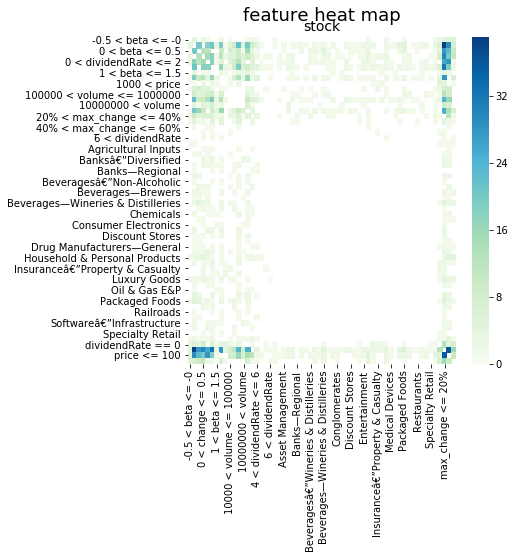

In [128]:
plt.figure(figsize=(6,6))
sns.heatmap(co_matrix_df,mask=co_matrix_df < 1,cmap='GnBu')
plt.title('stock', size = 14)
plt.suptitle('feature heat map',x = 0.435,y=0.95, fontsize=18)

# co-occurrence graph

In [22]:
from matplotlib import pyplot as plt
import networkx as nx

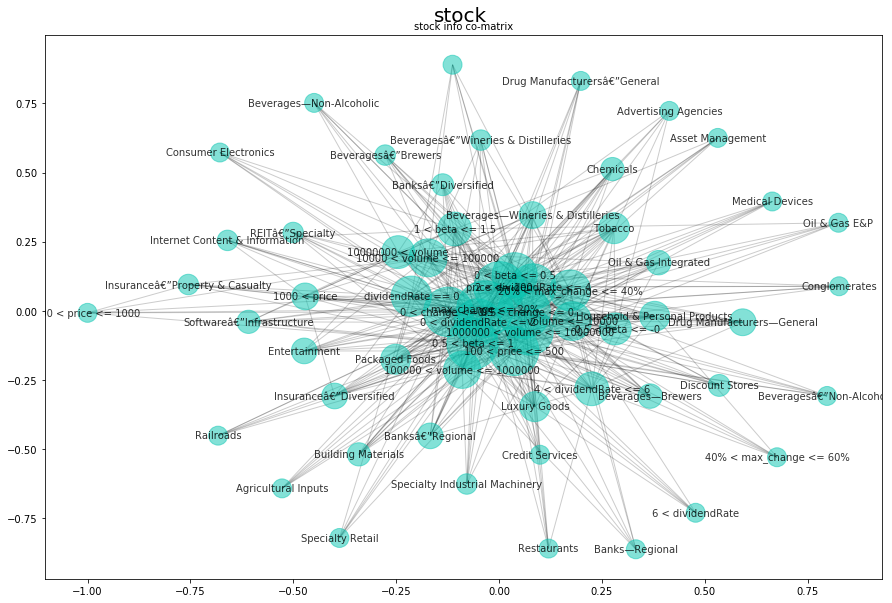

In [38]:
plt.figure(figsize=(15,10))
plt.rcParams['font.sans-serif'] = ['SimHei']   
plt.rcParams['font.family']='sans-serif'
g = nx.Graph()
g.add_weighted_edges_from(co_matrix_weight)
pos=nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, alpha=0.5,node_size=[val*60 for (node, val) in g.degree()], node_color='#08c5b1')
nx.draw_networkx_edges(g, pos, node_color='b', alpha=0.2)
# for p in pos:  # raise text positions
#     pos[p][1] = pos[p][1] + 0.03
nx.draw_networkx_labels(g, pos, font_size = 10, font_family='sans-serif', alpha=0.8)
plt.title('stock info co-matrix', size = 10)
plt.suptitle('stock',x = 0.51,y=0.92, fontsize=20)
#plt.savefig("用詞共線圖_以每筆通聯紀錄為一句.png", dpi=100)
plt.show()

In [108]:
co_matrix_weight_n = []
for each in co_matrix_weight:
    if each[2] > 20:
        co_matrix_weight_n.append(each)

In [109]:
edges = g.edges()
weights = [g[u][v]['weight'] for u,v in edges]

n_weights = []
for i in weights:
    n_weights.append((i-min(weights))/(max(weights)-min(weights)))

C:\Users\wells\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


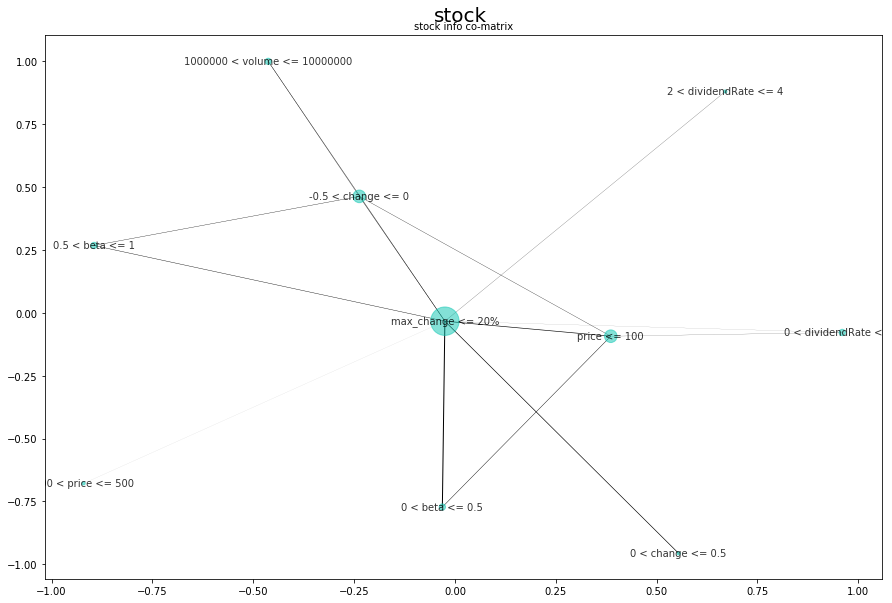

In [110]:
plt.figure(figsize=(15,10))
plt.rcParams['font.sans-serif'] = ['SimHei']   
plt.rcParams['font.family']='sans-serif'
g = nx.Graph()
g.add_weighted_edges_from(co_matrix_weight_n)
pos=nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, alpha=0.5,node_size=[val**2*10 for (node, val) in g.degree()], node_color='#08c5b1')
nx.draw_networkx_edges(g, pos, width=n_weights, node_color='b', alpha=1)
# for p in pos:  # raise text positions
#     pos[p][1] = pos[p][1] + 0.03
nx.draw_networkx_labels(g, pos, font_size = 10, font_family='sans-serif', alpha=0.8)
plt.title('stock info co-matrix', size = 10)
plt.suptitle('stock',x = 0.51,y=0.92, fontsize=20)
#plt.savefig("用詞共線圖_以每筆通聯紀錄為一句.png", dpi=100)
plt.show()

In [30]:
error

,Name,Ticker,Class,Shares,Change,Value,Change.1,% Port,% OS,Hist,Date
0,Anheuser-Busch InBev SA Restri,NaN,COM,49357,0,4702000,327000,0.04,NaN,Hist,09/30/2019
1,LT Group Inc,NaN,COM,1250000,0,336000,-35000,0.00,NaN,Hist,09/30/2019
2,CIR SPA/ADR,NaN,COM,125000,0,127000,-7000,0.00,NaN,Hist,09/30/2019
3,MILLER HERMAN INC,MLHR,Common,168781,-4935,7779000,14000,0.06,0.29,Hist,09/30/2019
4,PROCTER & GAMBLE Co,PG,Common,38837,-441,4831000,524000,0.04,0.00,Hist,09/30/2019
5,LINDT & SPRUENGLI AG-REG,LDSRF,Common,26,0,2154000,37000,0.02,NaN,Hist,09/30/2019
6,HEINEKEN NV /ADR/,HEINY,FOREIGN,28257,-100,1527000,-58000,0.01,NaN,Hist,09/30/2019
7,BB&T CORP,BBT,Common,10250,50,547000,46000,0.00,0.00,Hist,09/30/2019
8,PZ Cussons plc/ADR,PZCUF,COM,15000,0,37000,-4000,0.00,NaN,Hist,09/30/2019


In [19]:
import pandas as pd
df = pd.read_csv(r'StockPrice04.csv', encoding='utf8')

In [23]:
df

,PERMNO,date,TICKER,COMNAM,SHRCLS,DIVAMT,PRC,VOL
0,10001,20150102,EGAS,GAS NATURAL INC,NaN,NaN,11.02000,8644.0
1,10001,20150105,EGAS,GAS NATURAL INC,NaN,NaN,11.02000,7641.0
2,10001,20150106,EGAS,GAS NATURAL INC,NaN,NaN,10.90000,37576.0
3,10001,20150107,EGAS,GAS NATURAL INC,NaN,NaN,10.92000,26486.0
4,10001,20150108,EGAS,GAS NATURAL INC,NaN,NaN,10.98000,26332.0
5,10001,20150109,EGAS,GAS NATURAL INC,NaN,NaN,10.90000,15871.0
6,10001,20150112,EGAS,GAS NATURAL INC,NaN,NaN,10.71000,17662.0
7,10001,20150113,EGAS,GAS NATURAL INC,NaN,NaN,10.49000,122105.0
8,10001,20150114,EGAS,GAS NATURAL INC,NaN,NaN,10.46000,43486.0
9,10001,20150115,EGAS,GAS NATURAL INC,NaN,NaN,10.45000,29685.0


In [22]:
df[df['TICKER']=='BF']

,PERMNO,date,TICKER,COMNAM,SHRCLS,DIVAMT,PRC,VOL
4134273,29938,20150102,BF,BROWN FORMAN CORP,A,NaN,87.4800,5099.0
4134274,29938,20150105,BF,BROWN FORMAN CORP,A,NaN,87.9000,4962.0
4134275,29938,20150106,BF,BROWN FORMAN CORP,A,NaN,87.0000,7095.0
4134276,29938,20150107,BF,BROWN FORMAN CORP,A,NaN,89.0000,5358.0
4134277,29938,20150108,BF,BROWN FORMAN CORP,A,NaN,89.7500,9149.0
4134278,29938,20150109,BF,BROWN FORMAN CORP,A,NaN,88.8794,2717.0
4134279,29938,20150112,BF,BROWN FORMAN CORP,A,NaN,89.4100,5020.0
4134280,29938,20150113,BF,BROWN FORMAN CORP,A,NaN,89.4600,16474.0
4134281,29938,20150114,BF,BROWN FORMAN CORP,A,NaN,89.0901,7345.0
4134282,29938,20150115,BF,BROWN FORMAN CORP,A,NaN,89.4000,13192.0
